In [1]:
from my_utils.stardisting import load_published_he_model
from my_utils import tile_processing as tp

from stardist.bioimageio_utils import normalize
from stardist.matching import matching_dataset as scorer
import os
from tqdm import tqdm
import pandas as pd

In [2]:
base_folder = r"\\10.99.68.53\Digital pathology image lib\_Image libraries for training\2023-05-09 Published HE Nuclei Datasets"

In [3]:
model_name = '2D_versatile_he'
model = load_published_he_model(
    folder_to_write_new_model_folder=os.path.join(base_folder, "StarDist Segmentation Models"),
    name_for_new_model=model_name)

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
Using default values: prob_thresh=0.5, nms_thresh=0.4.

Ignore that, thresholds are: Thresholds(prob=0.6924782541382084, nms=0.3)


In [4]:
def write_row(column_names, values, df):
    row = pd.DataFrame(pd.Series(index=column_names)).T
    for c, col_name in enumerate(column_names):
        row[col_name] = values[c]
    return pd.concat([df, row], ignore_index=True, axis=0)

In [5]:
path_ints = os.path.join(base_folder, "Interpolations")
interpolations = os.listdir(path_ints)

In [6]:
taus = [0.5]
columns = ['Model', 'Interpolation', 'Dataset', 'Tile', 'Tau', 'TP', 'FP', 'FN', 'Precision', 'Recall', 'F1-Score', 'Panoptic Quality']
df_scores = pd.DataFrame(columns=columns)

In [7]:
for interpolation in tqdm(interpolations, desc='Interpolation'):
# for interpolation in [interpolations[0]]:
    path_datasets = os.path.join(path_ints, interpolation)
    for dataset in os.listdir(path_datasets):
    # for dataset in [os.listdir(path_datasets)[0]]:
        path_imgs = os.path.join(os.path.join(path_datasets, dataset), r'images')
        path_msks = os.path.join(os.path.join(path_datasets, dataset), r'masks')
        tile_sets = tp.TileSetReader([path_imgs, path_msks], ['.tif', '.tif']).tile_sets
        # [0]-basenames, [1][0]-images, [1][1]-gt, need to add [1][2]-pred
        tile_sets[1].append([])
        for i, img in enumerate(tile_sets[1][0]):
            img = normalize(img, pmin=1, pmax=99.8, axis=(0, 1, 2))
            pred, _ = model.predict_instances(img)
            tile_sets[1][2].append(pred)
            gt = tile_sets[1][1][i]
            gt, pred = tp.remove_margin_objects(gt, 5), tp.remove_margin_objects(pred, 5)
            for tau in taus:
            # for tau in [taus[0]]:
                scores = scorer([gt], [pred], thresh=tau, show_progress=False)._asdict()
                values = [model_name, interpolation, dataset, tile_sets[0][i], tau,
                          scores['tp'], scores['fp'], scores['fn'],
                          scores['precision'], scores['recall'], scores['f1'], scores['panoptic_quality']]
                df_scores = write_row(columns, values, df_scores)
            

Interpolation: 100%|██████████| 26/26 [11:55<00:00, 27.53s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1023.5, 1023.5, -0.5)

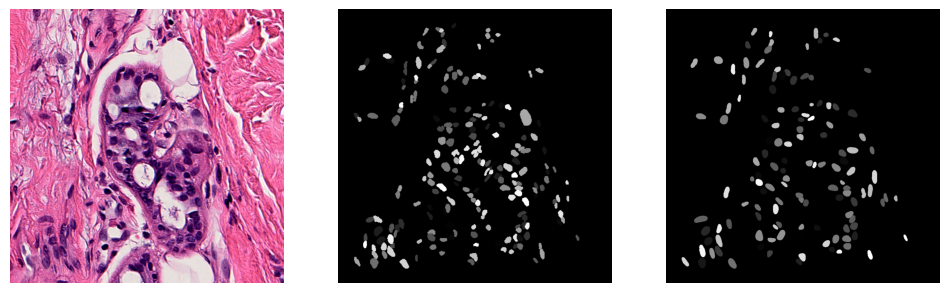

In [8]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # Adjust figsize as needed
axs[0].imshow(img, cmap='gray')
axs[0].axis('off')
axs[1].imshow(gt, cmap='gray')
axs[1].axis('off')
axs[2].imshow(pred, cmap='gray')
axs[2].axis('off')

In [9]:
df_scores

,Model,Interpolation,Dataset,Tile,Tau,TP,FP,FN,Precision,Recall,F1-Score,Panoptic Quality
0,2D_versatile_he,L - 20x - 0_,CoNSeP,test_1,0.5,36,11,659,0.765957,0.051799,0.097035,0.070160
1,2D_versatile_he,L - 20x - 0_,CoNSeP,test_10,0.5,66,21,574,0.758621,0.103125,0.181568,0.125161
2,2D_versatile_he,L - 20x - 0_,CoNSeP,test_11,0.5,91,59,775,0.606667,0.105081,0.179134,0.125938
3,2D_versatile_he,L - 20x - 0_,CoNSeP,test_12,0.5,26,8,294,0.764706,0.081250,0.146893,0.107169
4,2D_versatile_he,L - 20x - 0_,CoNSeP,test_13,0.5,111,29,1049,0.792857,0.095690,0.170769,0.126457
...,...,...,...,...,...,...,...,...,...,...,...,...
2621,2D_versatile_he,R - 40x - 3_,JHU,Skin_train_1,0.5,154,8,52,0.950617,0.747573,0.836957,0.647349
2622,2D_versatile_he,R - 40x - 3_,JHU,Skin_train_2,0.5,31,5,19,0.861111,0.620000,0.720930,0.571266
2623,2D_versatile_he,R - 40x - 3_,JHU,Skin_train_3,0.5,408,23,260,0.946636,0.610778,0.742493,0.575683
2624,2D_versatile_he,R - 40x - 3_,JHU,Skin_train_4,0.5,205,14,127,0.936073,0.617470,0.744102,0.593686


In [10]:
out_folder = r"\\10.99.68.53\Digital pathology image lib\_Image libraries for training\2023-05-09 Published HE Nuclei Datasets\Segmentation Scores on Interpolations"
df_scores.to_csv(os.path.join(out_folder, '2D_versatile_he.csv'), index=False)